<a href="https://colab.research.google.com/github/ariG23498/RNN_Viz/blob/master/RNN_gradient_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports
We will be importing the following packages:
1. numpy
2. matplotlib
3. urllib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# Data
We will be taking Shakespeare's work as our data. The data [url](https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt) is fetched from this [tensorflow tutorial on text generation](https://www.tensorflow.org/tutorials/text/text_generation). 

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
filename = 'input.txt'
urllib.request.urlretrieve(url, filename)

('input.txt', <http.client.HTTPMessage at 0x7f96359e60f0>)

## Data processing
In this section we read the `input.txt` file that is downloaded. Vocabulary is the unique characters in the entire text file. This is extracted so that we can generate characters with a constraint.

In [3]:
text = open('input.txt','r').read()[:20000]

vocab = sorted(set(text))
text_size, vocab_size = len(text), len(vocab)
print('Number of characters: {}'.format(text_size))
print('Number of unique characters:{}'.format(vocab_size))

Number of characters: 20000
Number of unique characters:58


Let us look at the first 250 characters in the input text.

In [4]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



Here we map the unique characters to specific indices.

A -> 0

B -> 1

and so on

This process helps us in converting characters to numbers and also vice versa. The input text file which is read, is converted to numbers instead of characters. Computers are always better with numbers.

In [5]:
char_to_ix = {c:ix for ix,c in enumerate(vocab)}
ix_to_char = np.array(vocab)
text_as_int = np.array([char_to_ix[c] for c in text])

In [6]:
i = 1
print('The first 5 mappings of char_to_ix')
for key, value in char_to_ix.items():
  print('{} : {}'.format(repr(key), value))
  if i == 5:
    break
  i += 1
print('The first 5 mappings of ix_to_char')
for ix, value in enumerate(ix_to_char[:5]):
  print('{} : {}'.format(ix, repr(value)))

The first 5 mappings of char_to_ix
'\n' : 0
' ' : 1
'!' : 2
"'" : 3
',' : 4
The first 5 mappings of ix_to_char
0 : '\n'
1 : ' '
2 : '!'
3 : "'"
4 : ','


# Hyperparameters
We are looking to have a hidden state of `100` dimensions. The recurrent neural network is to be unrolled for `25` time steps. The learning rate is chosen to as `0.1`. 

In [13]:
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# Model Parameters
To get into this part let us have a look at the formulas governing the Recurrent Neural Nets.

$$
h^{l}_{t} =\tanh\begin{pmatrix}
h^{l-1}_{t}\\
h^{l}_{t-1}
\end{pmatrix}
$$

The above equation is a simple representation of the recurrence formula. This shows that the present hidden state of layer $(l)$, depends on the present hidden state of the immediate lower layer $(l-1)$ and the immediate past $(t-1)$ hidden layer of the same layer. A little nuance of the representation is that we consider $h^{0}_{t}$ as the input layer. We can write $h^{0}_{t}$ as $x_{t}$.

We can break down the above representation in the following way.
$$
raw\_h^{l}_{t} =W_{h\_prev\_layer}h^{l-1}_{t}+W_{h\_prev\_time}h^{l}_{t-1}+b_{h}\\
\boxed{h^{l}_{t} =\tanh raw\_h^{l}_{t}}\\
\boxed{y^{l+1}_{t} =W_{y}\times h^{l}_{t}+b_{y}}
$$

The boxed equations are our concern here. The notations mean:
* $W_{h\_prev\_layer}$ - The weights concerned with the previous layer's hidden state.

* $W_{h\_prev\_time}$ - The weights concerned with the previous timestep's hidden state.

* $W_{y}$ - The weights concerend with the present hidden state.

In the code below we are using Recurrent Nets of depth 1. This means that the notation of $l$ can be ignored. The $h^{0}_{t}$ is replaced with $x_{t}$ for the same of simplicity.

In [14]:
Wxh = np.random.rand(hidden_size, vocab_size)*1e-1 # input to hidden
Whh = np.random.rand(hidden_size, hidden_size)*1e-1 # hidden to hidden
Why = np.random.rand(vocab_size, hidden_size)*1e-1 # hidden to output
bh = np.random.rand(hidden_size, 1)*1e-1 # hidden bias
by = np.random.rand(vocab_size, 1)*1e-1 # output bias

print("Size of Wxh: {}".format(Wxh.shape))
print("Size of Whh: {}".format(Whh.shape))
print("Size of Why: {}".format(Why.shape))
print("Size of bh: {}".format(bh.shape))
print("Size of by: {}".format(by.shape))

Size of Wxh: (100, 58)
Size of Whh: (100, 100)
Size of Why: (58, 100)
Size of bh: (100, 1)
Size of by: (58, 1)


# Loss Function
In this section we will decipher the loss function and the back-propagation algorithm. In a recurrent sequence model, the back-propagation has a fancy term hooked to it, the **back propagation through time**.

## Feed Forward
In the feed forward process, we move along the time step and evaluate the recurrence formula. The hidden state is then projected by a dense layer. The dense layer has `vocab` number of neurons. Each neuron spits out the `unnormalized log probability` of a character from the vocab.

* Neuron 1 -> `unnormalized log probability` of A
* Neuron 2 -> `unnormalized log probability` of B
* and so on

The loss is evaluated by passing the output projection through a softmax function. 
$$
p_{k} =\frac{e^{f_{k}}}{\sum _{j} e^{f_{j}}}\\
\boxed{\mathcal{L}_{t} =-\log p_{k}}
$$
Here $f_{j}$ is the output vector where $j = 0,1,2..,vocab$ and $k$ is the correct class. For each timestep we are presented with a loss. The total loss after an iteration is the aggregate of all the losses (for each time step).
$$
\boxed{\mathcal{L}_{total} =\sum ^{timestep}_{t=0}\mathcal{L}_{t}}
$$
## Back Propagation
In this stage we have to back-propagate the aggregated softmax losses. The name **back propagation through time** will make sense here. In this stage, we have to traverse from the last time step to the first time step of the RNN and back-propagate the gradients.

* First we need to derive the derivative of the projection $y$ wrt the loss $\mathcal{L}$.

$$
\boxed{\frac{\partial \mathcal{L}_{t}}{\partial y_{y}} =\ p_{j} -\mathbb{1}\{when\ j=k\}}
$$
* Next we have to formulate the derivative of $W_{y}$ wrt the loss $\mathcal{L}$.

$$
\frac{\partial y_{t}}{\partial W_{y}} =h_{t}\\
\frac{\partial \mathcal{L}_{t}}{\partial W_{y}} =\frac{\partial \mathcal{L}_{t}}{\partial y_{y}}\frac{\partial y_{t}}{\partial W_{y}}\\
\boxed{\frac{\partial \mathcal{L}_{t}}{\partial W_{y}} =\frac{\partial \mathcal{L}_{t}}{\partial y_{t}} h_{t}}
$$
* Here we formulate the derivative of the present hidden state $h_{t}$ wrt the loss $\mathcal{L}$.

$$
\frac{\partial y_{t}}{\partial h_{t}} =W_{y}\\
\frac{\partial \mathcal{L}_{t}}{\partial h_{t}} =\frac{\partial \mathcal{L}_{t}}{\partial y_{t}}\frac{\partial y_{t}}{\partial h_{t}}\\
\boxed{\frac{\partial \mathcal{L}_{t}}{\partial h_{t}} =\frac{\partial \mathcal{L}_{t}}{\partial y_{t}}W_{y}+\partial{h_{next}}}
$$
In this boxed equation there is a subtle thing to notice. The $\partial{h_{next}}$ is derivative that needs to be accounted for here. In the last time step, this derivative is taken to be all zeros, but as we traverse back in time, this derivative takes its own shape.
* Next we look at the derivative of $h_{raw\_t}$ wrt $\mathcal{L}$

$$
h_{t} =\tanh h_{raw\_t}\\
\frac{\partial h_{t}}{\partial h_{raw\_t}} =1-(\tanh h_{raw\_t})^{2}\\
\frac{\partial h_{t}}{\partial h_{raw\_t}} =1-h^{2}_{t}\\
\frac{\partial \mathcal{L}_{t}}{\partial h_{raw\_t}} =\frac{\partial \mathcal{L}_{t}}{\partial h_{t}}\frac{\partial h_{t}}{\partial h_{raw\_t}}\\
\boxed{\frac{\partial \mathcal{L}_{t}}{\partial h_{raw\_t}} =\frac{\partial \mathcal{L}_{t}}{\partial h_{t}}\left( 1-h^{2}_{t}\right)}
$$


* The derivative of $W_{x}$ wrt the loss $\mathcal{L}$ is as follows.

$$
\frac{\partial h_{t}}{\partial W_{x}} =x_{t}\\
\frac{\partial \mathcal{L}_{t}}{\partial W_{x}} =\frac{\partial \mathcal{L}_{t}}{\partial h_{t}}\frac{\partial h_{t}}{\partial W_{x}}\\
\boxed{\frac{\partial \mathcal{L}_{t}}{\partial W_{x}} =\frac{\partial \mathcal{L}_{t}}{\partial h_{t}} x_{t}}
$$
* The derivative of $W_{h}$ wrt the loss $\mathcal{L}$ is given below.

$$
\frac{\partial h_{t}}{\partial W_{h}} =h_{t-1}\\
\frac{\partial \mathcal{L}_{t}}{\partial W_{h}} =\frac{\partial \mathcal{L}_{t}}{\partial h_{t}}\frac{\partial h_{t}}{\partial W_{h}}\\
\boxed{\frac{\partial \mathcal{L}_{t}}{\partial W_{h}} =\frac{\partial \mathcal{L}_{t}}{\partial h_{t}} h_{t-1}}
$$
* The derivate of $h_{next}$ wrt the loss $\mathcal{L}$ is given below. This is important for us to evaluate so that the gradients flows properly through time. As one can notice in the feed forward of RNN, $h_{t-1}$ multiplies with $W_{h}$ flows through the $h_{raw\_t+1}$. This is what is accounted for here. In the last time step, due to the fact that there is no $h_{raw_t+1}$ we take this to be all zeros.

$$
\boxed{\partial h_{next} =\partial h_{raw\_t} W_{h}}
$$



In [17]:
def lossFun(inputs, targets, hprev, hist_grad=False):
  """
  This is the loss function
  Inputs:
    inputs- A list of integers for the input sequence
    targets- A list of integers for the target sequence
    hprev- The first hidden state h[t-1]
  Outputs:
    returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = hprev
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t],0] = 1
    hs[t] = np.tanh(np.matmul(Wxh, xs[t]) + np.matmul(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.matmul(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  if hist_grad == True:
    dWxh_list = []
    dWhh_list = []
    dWhy_list = []
    for t in reversed(range(len(inputs))):
      dy = np.copy(ps[t])
      dy[targets[t]] -= 1

      dWhy += np.matmul(dy, hs[t].T)
      dWhy_list.append(np.matmul(dy, hs[t].T))
      dby += dy

      dh = np.matmul(Why.T, dy) + dhnext # backprop into h
      dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity (1- tanh^2)
      dbh += dhraw

      dWxh += np.matmul(dhraw, xs[t].T)
      dWxh_list.append(np.matmul(dhraw, xs[t].T))
      dWhh += np.matmul(dhraw, hs[t-1].T)
      dWhh_list.append(np.matmul(dhraw, hs[t-1].T))
    return (dWxh_list, dWhh_list, dWhy_list)
  else:
    for t in reversed(range(len(inputs))):
      dy = np.copy(ps[t])
      dy[targets[t]] -= 1

      dWhy += np.matmul(dy, hs[t].T)
      dby += dy

      dh = np.matmul(Why.T, dy) + dhnext # backprop into h
      dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity (1- tanh^2)
      dbh += dhraw

      dWxh += np.matmul(dhraw, xs[t].T)
      dWhh += np.matmul(dhraw, hs[t-1].T)
      dhnext = np.matmul(Whh.T, dhraw)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

# Text generation function
This function will be used for inference. We will provide a seed character, and will expect this function to return us with generated text of the sequence size mentioned.

In [10]:
def text_generate(h, seed_ix, n):
  """ 
  A text generation function
  Inputs:
    h- memory state
    seed_ix- seed character index
    n- number of characters to generate
  Outputs:
    ixes- The generated character indices
    h_list- The hidden states corresponding to all the characters generated
  """
  x = np.zeros((vocab_size, 1)) #one hot encoding
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.matmul(Wxh, x) + np.matmul(Whh, h) + bh) #feed forward
    y = np.matmul(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = ix = np.random.choice(np.arange(len(vocab)),p=p.ravel()) #this is to leak a little information, provides a soft bound
    x = np.zeros((vocab_size, 1))
    x[ix,0] = 1
    ixes.append(ix)
  return ixes

# Train

In [11]:
from tqdm import tqdm

In [15]:
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad

smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

batches = text_size//(seq_length+1)
epoch = 0
try:
  while True:
    seq_pointer = 0
    hprev = np.zeros((hidden_size,1))
    # Inside an epoch
    for batch in tqdm(range(batches)):
      input = text_as_int[seq_pointer:seq_pointer+seq_length]
      target = text_as_int[seq_pointer+1:seq_pointer+seq_length+1]
      seq_pointer += seq_length
      # forward seq_length characters through the net and fetch gradient
      loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(input, target, hprev)
      # perform parameter update with Adagrad
      for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update
    # Outside an epoch
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    print('Epoch: {} loss: {}'.format(epoch, smooth_loss))
    epoch += 1

    sample_ix = text_generate(hprev, input[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n{}\n----'.format(txt))
except KeyboardInterrupt:
  print('End!')

  2%|▏         | 14/769 [00:00<00:05, 138.01it/s]

Epoch: 0 loss: 101.49356233763162
----
  uaii   wen eimrsc
 
tife.' n ogyoe
nnr;IiieLte n ehtui ; hlymgrtrgcers nRdhhiygsa lA eE rentn o,c  oyreamolA 
 eie uritteeieil
 o biefioieuohstinotao ,WidrsrlleyNiuiei ani:rmh  uei'hn io  tsitnaioia
----


  2%|▏         | 14/769 [00:00<00:05, 139.97it/s]

Epoch: 1 loss: 101.47268371601294
----
tAusruOwi t nwkmeir ae '-n tmeiueseehebtnl of   re  ephnnzirierwrgoigdrCin  ysee onnp
wat
:innn
Lra galiu  ars hi
s n n Ltoeo:i hd , h
oh labgh e :o eyam V nitec ptaotmrtNmeyhcihe 
aoopn r Iren 
er nu
----


  2%|▏         | 16/769 [00:00<00:04, 152.15it/s]

Epoch: 2 loss: 101.44944770132778
----
R'iine 

ooaMd a aaaum sregnrdealeehoeu yot nta agrLRtpe;A:s eoane cisaanorseitArd oiert nidh hge h eg
d h owL oad oasaet.iane t einnr  Moa

diilatc an;oenboeososot di t her;m Luhehe  tt nn rreerp om 
----


  2%|▏         | 15/769 [00:00<00:05, 143.74it/s]

Epoch: 3 loss: 101.42090773453714
----
saogaandes oru;esI art.sy.
olsnfe id srlon vo my,erl; m
AWhod thpln nIIbtiro trsod t on Vrt al
's ain t

d
bocomi hoh
VAs oer Vad byon I tee. Aloyr thebl rs hetythtod honsy go Ie deey fenyh iire hearn
----


  2%|▏         | 15/769 [00:00<00:05, 141.38it/s]

Epoch: 4 loss: 101.38854713583926
----
lar wathale; huer
Otftoer foaI,,  merat
 gpebme fopye aattou aw,
an potdi ateyeV:EAGIA rhso icren yoi eemar eh'e; , sogmoI
heit
Vle mon esr vRyl onmatsemsR-Hen s ouml.o: ougwnhonmwoyeWi hhe wel .oicti
----


  2%|▏         | 15/769 [00:00<00:05, 149.97it/s]

Epoch: 5 loss: 101.35291917558712
----
nt draryes hir onoitt roeop rours, ipu II ci: inntoes sol pLayem wy: y lifi loiteonntheon pole ;r ir won; nhonr aneoeke boren linLVwoldes can tiutee aLYeleceonhe
:
hame foesceenanyous mpad. Ierit.

VA
----


  2%|▏         | 14/769 [00:00<00:05, 137.92it/s]

Epoch: 6 loss: 101.31647740133154
----
ntberal it: hugir neall 'awhi.  thoridm mirs.
nenmmreap!  rers moe igLhad parere Anouldd hde: Ido; Iu ghomand thee grld uther
VAoroIs
Vn, at gothy omotbe.
Vie thepide.
Scan lut yos; Ieu wafons hoon:
'
----


  2%|▏         | 14/769 [00:00<00:05, 134.23it/s]

Epoch: 7 loss: 101.27970146187154
----
tziens he'g ng hont-eathu carilo' wir thaant
Atgog gzrkl iu truadtponaiu det yald pcan mam wtllanbich houor.s
VLIAm yhisp ,

Thercire itomos reumy y arow thed ius wotiinr ad
 aomat ghe,
Vheoy:
Rugos f
----


  2%|▏         | 15/769 [00:00<00:05, 142.95it/s]

Epoch: 8 loss: 101.24258930947838
----
reme the abes hor cmes eanr iripanTchit hd pat, ret deRhiln
VI mou,t gou gefeer aingy come thitsoulg: therild th !Rh:
:tine is yond wam.
 itor koe rin?

YoI Cigs cer thantgones? thoded.
VIROEDINII toa
----


  2%|▏         | 13/769 [00:00<00:05, 128.73it/s]

Epoch: 9 loss: 101.20512888030645
----
pin
VI
LRutooe in  onsI,; tiddius in sit . yinn
VMRLILINnGIhenshild orye ooer:

IAbd the gous ftheiss rof ans bifrintd inl hor esm Fasthes fi, fede maras won, It:
H:
Vpo, in har sof sinin'drorarr the 
----


  2%|▏         | 16/769 [00:00<00:04, 151.01it/s]

Epoch: 10 loss: 101.16749239101338
----
thid:
Tye igust lfs thar noot.
IS foves,'nd hI his.
UFobmes; he mancxk thn socas ous yfey bare He ath rorand erle h bathm tirait thius yag.
wheav thimttolghtan car nel, n po weast meay ton Co. an cemr
----


  2%|▏         | 15/769 [00:00<00:05, 144.49it/s]

Epoch: 11 loss: 101.13003849734227
----
n; Ir hney th sot .ersnnl, batr wout ovithrat hombt lon won sI! sh ooddttthoy routed

I:

INRh yiy. de.
Adrel dhle- Imave a ny ias onnsd rowet you mat th the the kooun, madatogone,
A: the.
The bustd y
----


  2%|▏         | 15/769 [00:00<00:05, 146.05it/s]

Epoch: 12 loss: 101.09244818966204
----
n haVIteigi the dateerat yogi'L

LINGIRG: hou cheeace Idin mraot tithi mikid hory doranif in rises eau wiin whobat gow kye wuen toThe anlm st mapansr apath. ernela:

Firorit yeus th; I io nal othey yo
----


  2%|▏         | 15/769 [00:00<00:05, 147.53it/s]

Epoch: 13 loss: 101.05455748421028
----
my,
Oegor? intond mer nans teert thr ? MaudU otit yirs, un;;
gu:
IsRIous anleow narte.
Acan,

I;:
Igaysedlis.

AFa-cous, there nogsy ure fu time gild hesyrey nour t so't agot aa ne te yiuth it fou IS!
----


  2%|▏         | 15/769 [00:00<00:05, 148.91it/s]

Epoch: 14 loss: 101.01706144855989
----
t br ch .
A:

fougir
Thons
Awte werarstgin yibot nom wa rya nof badstit thitry, yimk aost theerik fomes tdhe fp iwI:
gor Iod
NIINmenerisine:

VArkeou.

VLIA
bantlisere perriud,
I
IUULVALoofy fowd, you
----


  2%|▏         | 15/769 [00:00<00:05, 142.67it/s]

Epoch: 15 loss: 100.97988490428978
----
vot fve peis gwods that ber AENIU
ID:
Nens wagldet hont insem theC
Bor im pot the cot than ary,;int
I mois ceid lem?
 can; arleeren peizebesi
Vfedy is,
VMRUA VEaafe thmosot loray hongope weiuu Ielg; m
----


  2%|▏         | 14/769 [00:00<00:05, 137.72it/s]

Epoch: 16 loss: 100.94292502070205
----
r thecowknee lo hine
The baso mon hitir, yors nerer cofey rilhioqy bdy told ysor when lhont, toly pamimarth Iinicoius,
 a shmedan. d, lenes

ARyou tigWhee le, o wers; war.

Antent tI veret.
why noruu

----


  2%|▏         | 14/769 [00:00<00:05, 137.47it/s]

Epoch: 17 loss: 100.90637765706192
----
p het adars thauc .Yeneel' whe Lin: wer; thelr thaghand to
Ide
VGR:
phtt or ot he isR bus fyronm mid busAd mit be, coched
Bofive it, the fak I lid wer canl fune whil borun, lr harreitt,? ynu feinw son
----


  2%|▏         | 15/769 [00:00<00:05, 148.73it/s]

Epoch: 18 loss: 100.86992039086198
----
ntonldor.

SIAVIU:
AnVIAicot, nifitconicd lichablhe thew.
Selt it
Wfeor coudeitit renha toud, the Rithaur Vyes veer, arad voitoMo lat san baro ve sin sh hatthuw gus. sounge sorsf ir lony nathiun aad h
----


  2%|▏         | 15/769 [00:00<00:05, 147.17it/s]

Epoch: 19 loss: 100.83387203035696
----
f the fon ber sipnear hiwh me, co as yoms he to epro tatry thryit.
UENRAAs yadi.
Ses

IAits I.

VLEIRGV:
I thap emert ont wowre-mmida wiculu tat ton:

S:
Soud, he pau gay. the th, Iwi it hruy ewve wea
----


  2%|▏         | 15/769 [00:00<00:05, 145.99it/s]

Epoch: 20 loss: 100.79788905733302
----
ms.
Yot theeL
Ane; an avace onileit; upongozettha thar yone lirinmises ho mheunt o see Voe thittd cgi mes ard seve toondrit fan.

VEyhe
Vmy
Theris,
whes arw, waon yot; at sind ad yore hesmau alw, whro
----


  2%|▏         | 15/769 [00:00<00:05, 144.97it/s]

Epoch: 21 loss: 100.76203499504611
----
; he mung rapand that.

VeNhooge cuni it o dabesmen; ave.s pall?

VRLIAmetr Cir.

Lanut yor
Mann
I arne nome' thevere he mist yom,
IE
Touf, raum, ghaur nyos pit yowes.

VVyRoung'nll I gortt tor anstit
----


  2%|▏         | 15/769 [00:00<00:05, 146.52it/s]

Epoch: 22 loss: 100.72622783842549
----
n as miylike coneves an the ant?
Weantit ame- fmeald soy wes, dhesred fre bor be heet
I, Mfey
VVALIApsr si, toud uns Vout goun thr, mariteltee moad?
 gersersor ir bupi,
Doe pot o thind ou im vadmth ha
----


  2%|▏         | 15/769 [00:00<00:05, 148.35it/s]

Epoch: 23 loss: 100.69032857620837
----
d gay anl; goou
stbout ct; ciby gondrst ar pre your
Her imthaRbaiu hof fi haden hed hars 'ls dene ssheilcmy mibt.
On inrer the lam nerald a geve or: I arkad dateun; pot ow ssodecide llyI luther sfin.

----


  2%|▏         | 15/769 [00:00<00:05, 146.02it/s]

Epoch: 24 loss: 100.65501463203236
----
d: el hpo
I
VRI
VENIALRIRGI:
Aa an :
Thu, maled lame I.  hars bortistment nom so yor af tor atdoully
it: tht hud rod atd pis.

UUS:
VVSgauf tot mus'p I taaud'cne till ci sor norren, fou syove mome orc
----


  2%|▏         | 14/769 [00:00<00:05, 139.83it/s]

Epoch: 25 loss: 100.61973673751626
----
ust gneat ir hes and fod meakim fare hid.
stito rmote dyiblcebotil esin pill, thly moutst toudsenreon:
gom you less the mim emaghat ss,
Aermd coag re st atim fer nil hasd le cers' noa' matsen:

I
nour
----


  2%|▏         | 16/769 [00:00<00:04, 152.64it/s]

Epoch: 26 loss: 100.58443253140274
----
rh gis.
 nt.
dotes, :
Chode wif an'jer.

MIA: py,.

VARIA:
NII, yot?
Wers he nieriporempyesd meacd doneas awtdocis whecaral; e.

VIAng maner sol foey ;the.
Vim ,
VCELIA: stit I'n: the prayawl oor beme
----


  2%|▏         | 15/769 [00:00<00:05, 148.12it/s]

Epoch: 27 loss: 100.54899297161853
----
d thems wed yuwhansinste condraase yonl, apit pirirsr carat thalala,

V:
VAm
I; that we mr e end I anmty, I erone bak thas farins thes I, mip shald, maun, thet thyon do the wit trin fsrond toud dol mv
----


  2%|▏         | 14/769 [00:00<00:05, 132.94it/s]

Epoch: 28 loss: 100.51343351901333
----
ve v: whag li. IA
The maitit hiy worimr are is tasr.

VALVALagssiok yod hous yot is fen. Coemarirr the- hisfit aome? ance pere- yous i fomos in the
enos; sekeinty: yof sashow ire geths; the aljey tafs
----


  2%|▏         | 14/769 [00:00<00:05, 134.13it/s]

Epoch: 29 loss: 100.47775396537408
----
imy I ILfaufasV: als yonm tetre ay chey ite stas heemy kanle iunlt it. house ir
set fin; yoy arave ceinil: I Thrmers.
Heilc.

Mfitheen
ste on the  pat rate neirnd meoos annse anhe arnir? desVne! If; t
----


  2%|▏         | 16/769 [00:00<00:04, 153.79it/s]

Epoch: 30 loss: 100.44194477109728
----
t, we gat ustdor ve scamiblliri dmiwnsty with ta
VoLIULNII togiod ror ist ink bereLt werond bll:
In: met Id a som, atheneyeng,s I malper cem mes,
Thawin mar hat.

SI theain wengeml, 'oulist mit; Mocsh
----


  2%|▏         | 16/769 [00:00<00:04, 150.78it/s]

Epoch: 31 loss: 100.40617594513178
----
nte.

VANUS: wi:
mery the ant on halr ant to the ty dowave melh to' cLis yet aa thoest halh gou were moritis nog wot cold ou Cie threy yro
Anedestreve's gas s. wotit,s
Sour?

Fazan emichadn? wars prey
----


  2%|▏         | 15/769 [00:00<00:05, 142.92it/s]

Epoch: 32 loss: 100.37058252066772
----
se I,wed me swif wiin sis yow nocveande ad wo, 
GI RININGGOLVINIA:
Hithet cit. Whey thort whist got erile the he ghif shi:
Our:
BECILaneny us: our s.

VALESIRINIAery not co har
Ceiny cout pally ded.


----


  2%|▏         | 15/769 [00:00<00:05, 148.54it/s]

Epoch: 33 loss: 100.33499848075284
----
d hataid der er hlolt huaus the i, botagibcavithin: as heted ret scon tieche, baiugved wee meon bond amus freo wothir nould cayeand thlucleceter buy theln a'nnheles; mel' of oVand prist goustcenut dot
----


  2%|▏         | 16/769 [00:00<00:04, 153.00it/s]

Epoch: 34 loss: 100.2992386894394
----
us I suga, guemle, g and the your
Vek-t
ejeas fow: Thens, whig, thaer dot oud.

Fenorst wheerrito hirt af, onn'tnWh, an redas yom bea thot yat cove teapeend erap.
Whe I de ur camer whemy
Aind norat th
----


  2%|▏         | 15/769 [00:00<00:05, 142.07it/s]

Epoch: 35 loss: 100.26352915183392
----
in sbat ould it fomst. Arasb,
Thloldind, no draond thay gmald celnt want vat; thetcove fr.

VIR:
whae der as, estiums huel anlall's ak'
 amaghe lale fon I, Rot chek thes mr, theill b, ghemy foond ye y
----


  2%|▏         | 15/769 [00:00<00:05, 147.50it/s]

Epoch: 36 loss: 100.22779824513572
----
tsr an; syood youl youe
'cilcot toMn: the thoy mow o's,
An;
I arss dars
OLelellam fo,
'wher whor; gon.

AS:
On yoll, for for thy mly go habul youd, thid im Lerry as yout prear yoodaws the nelleded.

V
----


  2%|▏         | 14/769 [00:00<00:05, 138.28it/s]

Epoch: 37 loss: 100.19174888605293
----
t tower he head thind an mite doond, he ofras.
Af hariwI' oons.

VIRO a itthadn appreave fo'.

VRAmengfe ond soy was st.  urtmauge.
Omawey wan; sameneqed
Wet pre noice lars songuest.
Mfe mere is;
OR w
----


  2%|▏         | 16/769 [00:00<00:05, 149.81it/s]

Epoch: 38 loss: 100.1558242569048
----
l: mcene har.
Singreanm sir mulms able tins artser: sin'- meve to, tatw
Honth you yiurs hats, sto, I whe tom.

VVILI'atondr thattoms Whr, redth it Anvell;
Tay on:e
VId,
I gim malilt catornall dorneood
----


  2%|▏         | 16/769 [00:00<00:04, 150.65it/s]

Epoch: 39 loss: 100.11947350322963
----
ns yous is gisenue co ancw:
I yo' I uth it hollh the rer, thit ofsowdst freeveny elthe an and tutoodse'st the ondoe the the Vod bathine muthets owko gogheis Ram The'ld FitAven:
Aryot
Omate anneou vith
----


  2%|▏         | 16/769 [00:00<00:04, 153.13it/s]

Epoch: 40 loss: 100.08317376685761
----
recheLee a peerermes.

VALlithipty
IUS:
IAas! bovenry at enhe intyangan wavey
I
SVA:
Cou:
MTI:
Aatmof cedst,
gom an co meanne henly I yot
I

VORGGILIULGGIA sudnemt. I we ofen.

VUerI arsheird, ild gun
----


  2%|▏         | 14/769 [00:00<00:05, 133.08it/s]

Epoch: 41 loss: 100.04725652996795
----
, the icninsuod; thiblt fpees.

ALanners LEm hes youg arm Ay malkme wade UR pser alif dion deay shadey farey co,
IU
Fallit. ikt sthe yous,
Im you ciar be strancis, ollomakyeneres angner it, shind t'lu
----


  2%|▏         | 15/769 [00:00<00:05, 149.31it/s]

Epoch: 42 loss: 100.01139906549434
----
our

MALE'babth stit core
Remy mu naindeogir Lem,.

VRGI toe Theld, I irniumars
 is be,
Vee fore herb, kiar nor::
Rou boold you warpein is it nerrot;
Tor: it yot he ainglocar,
I ratir nopt werad. Andr
----


  2%|▏         | 15/769 [00:00<00:05, 148.90it/s]

Epoch: 43 loss: 99.97545675806357
----
irs arn hem'yh it porwe'bor m tow col wame good th s aand,
Rory farik talim; aum if en inerer goof the be
Amcaily in hptike it, hire fof,
I cathy pand then hy golve collere?
gond I wire nall yon wos, 
----


  2%|▏         | 15/769 [00:00<00:05, 147.81it/s]

Epoch: 44 loss: 99.93945278115916
----
l; and aand; sound il wat:
Whey caved ridce, turere ins ense ore
hilals fies nheir:
Mathee
 hiis apel
Weeve the the; I an Joll; tor witir siuke anp!

VFnedemmy lors! wEmam, at your: I his thouptcil ou
----


  2%|▏         | 13/769 [00:00<00:06, 125.32it/s]

Epoch: 45 loss: 99.90345519594129
----
osist. I lot, the el, the  rra.

MRsuustise hist tans hif I avey lhe dour whay ha at bove enicot is
Af oore metit, ond wuld easit ollo
I, Omtaad ther:
Whus it mmad datay Vicaaly ind le, I hesindy thid
----


  2%|▏         | 15/769 [00:00<00:05, 146.38it/s]

Epoch: 46 loss: 99.8672437242812
----
ne mlol. Ma izis izet me you
Anonlkem innderesw hael sour gonhen the yit oame anvmirwim whet mures im ssad firs armcet tawsround. whe. dad sang am youith the with ppsur welagh, noth een thest prut hf 
----


  2%|▏         | 15/769 [00:00<00:05, 145.93it/s]

Epoch: 47 loss: 99.8309213177046
----
t; I'
peelliis:
Onf to youc pes
Cot erey, thi ser matweandich tureve but'
Mofe. I irsgontef he'pe ackely ust, fteak of whe I' ad we arcreald arst: wad hhllois, thed cof my, yuu porer.

Finradty hatle 
----


  2%|▏         | 14/769 [00:00<00:05, 136.93it/s]

Epoch: 48 loss: 99.79466114824613
----
tt I all I dpeves sfrad fopr, ome cabreyA igoul,
Arakir me tpy
Allind ppallonstheer,
I,.
Tangror art wer he peele an me. I andnotine velcamen:
I see
Somlat; thes tathe.

VIRGILIRGILIA:
Tfit's wius.
Wy
----


  2%|▏         | 12/769 [00:00<00:06, 113.86it/s]

Epoch: 49 loss: 99.75819446356851
----
'm arst res ower gows pautns.

OMNIy: I upbees the kis
yor INod prow wan: porr mamt therndeis, dont onr foon-e wow

VIRIbac'on hime thi go Mais, po pyou toredace whet el toeed:
Ia ig tilhith shals hin
----


  2%|▏         | 13/769 [00:00<00:05, 129.29it/s]

Epoch: 50 loss: 99.72164124997208
----
ne, Isen.
Ond,
chis hamitore H yans land le noum youeth ser erins tLoble gour goa yoriwh miliok.

VIURUENIionse attarest do iingevestle of woun ould leeril or pamy shacis you?
RCaMhale thin can pank, 
----


  2%|▏         | 13/769 [00:00<00:05, 126.24it/s]

Epoch: 51 loss: 99.68495440657843
----
s sbnornead her ad meall scen.

VIAELI:
Nanomakid; his sons n thene prain; be, I the bor not al shyuc; ven: bus gouptec
cou ulldUsed, hir the is. fot to mane erst, toucns you, arn urelinapay.

VIRGILI
----


  2%|▏         | 15/769 [00:00<00:05, 142.00it/s]

Epoch: 52 loss: 99.64790383378654
----
unintithr.
hanreld wiain aoth urast tethen Cit Cit,
Vhey dere mn.

VALEA:
VerAO athome
Aamme yoanh oumere the dugee pedley eld at?

ERIA:
They aranMAROFIUTUy cottidmy ther teneatine ind wile micee kol
----


  2%|▏         | 15/769 [00:00<00:05, 142.32it/s]

Epoch: 53 loss: 99.61047091335888
----
uls,
I he sems.

ENIUTVITIAep anelly me my vaol yhe goontarnnof ruded ant, we iple we warveenteeve mlel hamlay,.
Thop denh ours.
de taplig knou to mengo thercow renom and wabt, saf,: yorpome,
Thet I w
----


  2%|▏         | 16/769 [00:00<00:04, 153.61it/s]

Epoch: 54 loss: 99.57262291527692
----
tiw wereranger Hom belam hads alt yor oll:
VA:
had brenyiy amur lrRCaCathe woy sey on
Woss you:
Isrey hey boy the. As; did wek?

ToCIind ingrmeing arce mith Ifer cather; to I yoo you hangrigurs nnhle 
----


  2%|▏         | 16/769 [00:00<00:04, 154.74it/s]

Epoch: 55 loss: 99.53440437533135
----
e hanfolede dered wame hithlits fhrad yopreant the Cenown wame ankLouuli y: the yours; ii hiteerted hithr of iul, anther I than preome I'll notcethriur sweringetamol iscled hand, thet the paey sacache
----


  2%|▏         | 15/769 [00:00<00:05, 138.65it/s]

Epoch: 56 loss: 99.49572152957762
----
olleiu! mher:
Whas ad fraaveres' arerly he hor cut

Ay cam. bodorts ar; wo sorews
Ronwite fshaln, upreodino siit apan-RGbrst, boll proris aud katt sas,
Irsnove it leant thet.
dows'ts him, pro storofed
----


  2%|▏         | 16/769 [00:00<00:04, 153.68it/s]

Epoch: 57 loss: 99.45646819163375
----
in; bus aplok, no patiokser or in fellot kir I'rs sad hajang, watd maros
 hitize cas yoe. many, hine awive wite ar mp wakeey, I mild, rathe nerers lath tole mato IRelout ar wor'p.

VIRIA:
Bet lormast,
----


  2%|▏         | 14/769 [00:00<00:05, 135.65it/s]

Epoch: 58 loss: 99.41678271234098
----
lrl.
Mload, I cprithhat shato thive archan mlat, you the is you.

VIA:
Soleafr, in I wis mulasely don mh ares ar that you

VILIA:
I Iill ir nomlly:
Hoy ara woncdingenger shbar care
Von the it shaly an
----


  2%|▏         | 14/769 [00:00<00:05, 134.17it/s]

Epoch: 59 loss: 99.37650570926685
----
chemy'y I: cofendst: Circhot had'e imer-To hu ushe ived: I's ney bem, is eners Corote mo tath hill I wor Thougrand.

VIRGIAj:
Ven cLI Copat wared whey. watare most
If IUb,
Hes dait you:
Wiskis s wi? h
----


  2%|▏         | 16/769 [00:00<00:04, 151.45it/s]

Epoch: 60 loss: 99.33592285628083
----
n; pous, yowere it, Aird,
Ttow mits co haw urnss antiblo
If guik ry is ra ratio the thoy siceand,
Micis oMA:
Snobbo to my prous for makedrenot leachy noty Of nory mathen 'so the fLatikn and small co c
----


  2%|▏         | 16/769 [00:00<00:04, 151.42it/s]

Epoch: 61 loss: 99.29537525967764
----
us lilobeang shood wour sfo , I manerndirnnallverst tyoodellyer lorvad starall.
Shy yoves mafreread noun my it renetoltyou
mogpr liy ol I hit woris omer tosd the onas fomy malyoum, tle whe itoke?

VID
----


  2%|▏         | 15/769 [00:00<00:05, 146.24it/s]

Epoch: 62 loss: 99.25402776836563
----
nger.
Faaly, gollat; hhede'MNow, I webipfivon his. An

ull, Iy, thty ti fret and nibatcald werotcsenksthes rathe darim noblaras tof quiin pis tile goodseank ibc?

OLUS:
Oit are lomell Vord thadats fal
----


  2%|▏         | 15/769 [00:00<00:05, 147.41it/s]

Epoch: 63 loss: 99.21254759989637
----
efirsis you:
Het, in ngraangeatome cout senedst
you alp at sirst I all mamere mingelp artand bse,
VOd mome it; deam; that he rpeingirt; swtiglanlliomyourddave vili the thele dait is
wade.
The non blir
----


  2%|▏         | 15/769 [00:00<00:05, 147.50it/s]

Epoch: 64 loss: 99.17093206759803
----
my yoaveration mis wererangmelaatim st, ist waplre are glorst of chid; natich youund llmivell ars the ar c I ame bey in gead lims.

VIRIA:
Ifwesels of liadieg
Af norat
medbamrne nould is wolves fank,

----


  2%|▏         | 16/769 [00:00<00:04, 151.29it/s]

Epoch: 65 loss: 99.12947820795914
----
goill it merrst boilt in ewy, cere,
He us the wored kale wmam,
Pyieseave Miughire arnethuprelin: be; Of tarearch hamerty my yof freavoully
Matik
We boringing innout nore wore lllen mive, you picawer b
----


  2%|▏         | 15/769 [00:00<00:05, 148.51it/s]

Epoch: 66 loss: 99.08791109469227
----
tenkenncyr? nom: your hedry,
Wheve teresenoby ITUS:
Lire forved to do lowim shanc ars!

VIRGILIRGILIRGILIA:
IDand bathyur;
swak il to you mast, ous mald youedeued hamabcnest; ne ferall. the cotheurs w
----


  2%|▏         | 16/769 [00:00<00:04, 153.65it/s]

Epoch: 67 loss: 99.04620982263256
----
uth:
Sall: a'lllely nom, Vowthius loutizense you toshingf telithenghe the crme, Vno noull cithrae sotcor goug, thes hawe thalke, the heandeter mice thut ond, I fistioe havith stortelllean to the meavt
----


  2%|▏         | 15/769 [00:00<00:05, 141.74it/s]

Epoch: 68 loss: 99.00416345362157
----
nenghed you thes ourghit has chuch cmand mtyou
Wer souelit Cim wa, beeader we.

AmRStond my an bdors orhik
The wanr bathies the ware you wims th ic lipe whal. Mare paansen hmilu butherant magtily god,
----


  2%|▏         | 15/769 [00:00<00:05, 147.72it/s]

Epoch: 69 loss: 98.96183815886458
----
zenffow firs ery deul smar:
Thang;
The coran; is yout, I enk?

VIRGILIA:
MALERerowa uno beiove:

VOLUSernry haye
They and cathir:
as, healmes in onk gan aat greviblith arine pou; it our they your anss
----


  2%|▏         | 14/769 [00:00<00:05, 139.14it/s]

Epoch: 70 loss: 98.91961781072287
----
ttrt yom mo'ty
int,
A; modnithew.

VARUnFof watheame
Yae ordotedant; en it cor: onll, I,
Iw nor: gtar!
Sein madain.

myRGIA: pound aa panichemeplat of wats, nosA anerain me mor:
Set; lest
Fartit I'Sco
----


  2%|▏         | 15/769 [00:00<00:05, 149.66it/s]

Epoch: 71 loss: 98.87742372427464
----
ze on the both.

VIS:Cim weabltooct'on'd adnem, spamproctizeds!'d male
Yonky batn.

VIRGIL:
Gasp,'f to aomf, hean wonry hititince shent stertize-y yoy at tirt suchins, tyour thabethe cimy a lice,
Whey
----


  2%|▏         | 13/769 [00:00<00:06, 122.68it/s]

Epoch: 72 loss: 98.83514157174974
----
me your instered you or, by lomriredrat proldry, I madiur mowh amenert'sh you hang it
Eoreth ham in
Hect anr thom: eithers ceattolimfjede. 'cey theceyound; I

VILIA:
Bishere dingsh warse reheat to ing
----


  2%|▏         | 15/769 [00:00<00:05, 147.94it/s]

Epoch: 73 loss: 98.79284957186425
----
e;
Whaghas toll.

MENENIA I atherhellthen wecave limned ast co'd the 'n then:
Jure tit go kus to I, unfreivery ga the notesxeriuse on hame that trf, lamy swonty
IA swarcaf onjorlald micI alm cath then
----


  2%|▏         | 13/769 [00:00<00:06, 124.19it/s]

Epoch: 74 loss: 98.75054897265531
----
myiy,,
hy mo pis enenowenchighowh.

Thav madloer: des, heango's themiy, I pilindend in the my daevith, whe and dantaonve you no ast me Se, fould goothad'urese com Romist for fsor:
I hisoumy to you

Ma
----


  2%|▏         | 15/769 [00:00<00:05, 148.44it/s]

Epoch: 75 loss: 98.70829680332149
----
tich.
Nmak
Senty ond worer of or jeenemly it knice paeld: hod, nomar!
Ferelf thet tronh. I the'st were acelrer the you noter banacchis chererw ir lancitis, stamy reveds:
He lllecut ins me. I foms.

Fi
----


  2%|▏         | 14/769 [00:00<00:05, 130.91it/s]

Epoch: 76 loss: 98.66612859826085
----
nirs, the rered beiave wors.

RCIAiriod the
Hell the stons ralt stthoust thoultaritnow atiu, cae goon: alc the groum-.

VIRGILGint her jeser fit colisbproins.

Mt Ihay
sheracaghere ol is ceach reamy i
----


  2%|▏         | 14/769 [00:00<00:05, 138.72it/s]

Epoch: 77 loss: 98.62414875933264
----
,. gidreinf thaaodicouf'-, arm
We spacke sour
No maliniuny cerswisil souplears you I sorse Laivitheenll  hescare

ARCCIUS:
Thererat
alleLit thase winomsts;
in CoorI I-lay,, nelfon bus sad we;
Wheat fo
----


  2%|▏         | 15/769 [00:00<00:05, 147.18it/s]

Epoch: 78 loss: 98.58241648010316
----
s his tore mothead I afoud,
Thant
Anach nobnveindst Come nower tol.

VALERGILIAIl:
Thail.

Andet me ius, the Labems's the fidaling
If-A quot mthmodill I shate vI to vfow himy,D
Haap'ssrysy CoMemawes
d
----


  2%|▏         | 15/769 [00:00<00:05, 146.03it/s]

Epoch: 79 loss: 98.54071454778372
----
ve tht, in bue hiugee worald s pres; meae whoancerie poony uld I at to' prnither and yout? ser.

SINIUSCOLORGILIA:
Ant my, to ad eritiun

I
VIRGILIA:
Ofthit.

VALEIRGILILIA:
AnxNourn:
To
Niminge, I om
----


  2%|▏         | 14/769 [00:00<00:05, 139.05it/s]

Epoch: 80 loss: 98.49903900952584
----
en.
Vo'cid he.
Will the ghenom. fhis, dol ased it that towaly sor an whour and in, of it you ambrelis lakamit mongbe sircithich to mus! 'sould
ToredoctinitWires and kich.
 herim talyincarenes, the
Men
----


  2%|▏         | 15/769 [00:00<00:05, 148.86it/s]

Epoch: 81 loss: 98.45710039431268
----
nimste, ar wamaun
He peat of com dteread, hink hyike ha noprotelle VUlay o tied, noce, had, in looks on the patton.

VIy:
LangTlawh, wield plmeut toll Aughers follize ches.
dom! sher. 'ntell 'at of th
----


  2%|▏         | 15/769 [00:00<00:05, 146.41it/s]

Epoch: 82 loss: 98.41486152120646
----
ady goo wark, and tyey wishe momsithe, whresend ghes, the keve thar yould gom Stoplake hiceard, like coull'--

ALERCIUS:
Cobd cit to assbowne, fary.

Firstrer, elran oulrely brhourd
Inser!

VIRGILIAth
----


  2%|▏         | 15/769 [00:00<00:05, 146.72it/s]

Epoch: 83 loss: 98.37240258050933
----
s welvir.

VOLEAem:
whies.
We cond it fingenmalyiniston in bupit I meree an hif the th towe to thes.

VALA
FIUS:
Anh awe four and in hay hesr seoll the gim'd the not corst sula?
Hest we. devad gray th
----


  2%|▏         | 15/769 [00:00<00:05, 147.53it/s]

Epoch: 84 loss: 98.32957947407537
----
ughe
ir you bodrle fomy levorce not ar mo stawe hed the toonthiplu ver gritA sect oonfadit fowelfen he bellad meden sstingrer fure ghe and thinst, Auf:
They hiselllest: thor gindith the uses foon fcer
----


  2%|▏         | 13/769 [00:00<00:05, 128.57it/s]

Epoch: 85 loss: 98.28621360825056
----
ip, Barabret Marsh lnd Igay with wheme reade
hord fare, benger word Cinge?

VIRGILIA:
On honteon,
Of louus matchinscofthsw a mineens and it sad sames ur. connos, mopry gow senttatiy the bibkteve his l
----


  2%|▏         | 16/769 [00:00<00:04, 152.61it/s]

Epoch: 86 loss: 98.24224736094233
----
cin
redest ull irst he a taly die sale rathenes hap lakis
He chim.

VILIA:
I bnaad.
nneyomar'y. thain.

MENarath heir
sured, an it lich gooide
 whawe fonape'llle pemephin; thee Citizen:
Lerer alabs; o
----


  2%|▏         | 15/769 [00:00<00:05, 146.59it/s]

Epoch: 87 loss: 98.19762091196914
----
rs,
Home murllitht, hund corcius. I

VIS:
Their instreshy homcis los ele Lo'S'ld: dithy taresed becion ching.
As cowh at o- nrer and moding wheinaid.
Live ratiriod this eith wan thor cofthiit'f: oumec
----


  2%|▏         | 14/769 [00:00<00:05, 131.14it/s]

Epoch: 88 loss: 98.15247895225959
----
de kfreaullwer it o owhing.
Thate
sing! I hare our
'le mite us lo, th yoodns are aghonss ste
You urtis Ciscandek:
Sefnou-: I arik blly therell!
To his cablu brmepaal wentyor ghel ow make minhe cour fi
----


  1%|▏         | 10/769 [00:00<00:07, 95.13it/s]

Epoch: 89 loss: 98.10693904168505
----
t, pir. ILead mmor arst thomach olly
Noe you
Are Volisich; wians in to thens ble win, mosto go the artik, you and, you than uund tiod. That ed blolg me muth, id. Wevighor you pristing hour erbnourmyey
----


  2%|▏         | 14/769 [00:00<00:05, 132.11it/s]

Epoch: 90 loss: 98.06133392004283
----
ng hew heit the joor thes, kire ce catd in hhis it eew: Melly.

VALERUFirnot ead bricirsiriw follessore ar martiut cuen hinghat oL:
Cominduch sistafece nomy,',
When in to thead, you wenenengrir: hulve
----


  2%|▏         | 15/769 [00:00<00:05, 149.97it/s]

Epoch: 91 loss: 98.0152582866132
----
ngund the itd
fgre vorsir maly afm,
Youn ory:
prew hen,
she were badit h. I ararssyy, latkid.
Buty taed mapriiiuss, his norrom rebsfed, the sas? wald nolllle youwizengele mlougyhe ditom.

V'TUMA:
Firi
----


  2%|▏         | 13/769 [00:00<00:05, 128.23it/s]

Epoch: 92 loss: 97.96920091402097
----
ry, bus'y, mcae cere, upridines frowe have, I derere,
Inder.
BI ably bs,
I murch ith: how yor, pice ofore; surer
The batowe panich farit I'd mod to dit? Marciren Intem, kovind th deon spely, hamf the 
----


  2%|▏         | 15/769 [00:00<00:05, 146.38it/s]

Epoch: 93 loss: 97.92301710626221
----
ly bebendatheasaly unk laleake atanachey,
Is ans enoncord fomy, ware they, woup
I the ase stall cod quncuch, hancetsthite.
'theor nor: en the arond, you fiust shesw,
ronems.
Coirem, hegeart; mike,
yau
----


  2%|▏         | 14/769 [00:00<00:05, 129.77it/s]

Epoch: 94 loss: 97.87696045123955
----
red shaw atcusentain horverest roumus, amaroupt; oid'Th the arser'h shver Citizent wis'rit must ofnank
Unon to gomer ramers day?t ang'y
Our at, wor buin, -alith yowhi;'ll het'so bewh wam
izesveando fi
----


  2%|▏         | 15/769 [00:00<00:05, 147.80it/s]

Epoch: 95 loss: 97.8308314123626
----
n toe
VAtLCIoon laintonr son diec this?
Haspiand orighood halis, ane youping ghave
had Vamy'e srothepead in toI
Bines
Cothar. I nencetroont your you that-'s cate dor I ofor yoy of fit; chire Mamy cork
----


  2%|▏         | 15/769 [00:00<00:05, 145.48it/s]

Epoch: 96 loss: 97.78495890372191
----
rts I toumm shetaditd: you dompe.

VALERICIUS Oll: Ifth ald you recangs core all wady, was bufs, maghnoy whichreig.
Thaat toon
fenangt Matizen: inssy you lich ald, harave pumina, the:
'sh deroronge.


----


  2%|▏         | 16/769 [00:00<00:05, 150.43it/s]

Epoch: 97 loss: 97.7389182786209
----
t to yoursellle were sere.

VIRGIDIUS:
Balinat stry alls he fweanderm; good; hat'st Satoney:
Bom mo guratiss whive murely comlost in hatcun wan at hy
stafthe himighf.

VIRGILIRIUS:
UMNIAsily, wits rat
----


  2%|▏         | 15/769 [00:00<00:05, 148.71it/s]

Epoch: 98 loss: 97.69293224307829
----
ntper. Hamad his malf? the fout. No've

VIRGILIA:
Indolly; thy, nele com
merey's Stiun Vamy.

VIRGILINIUS: irsenvesen snotneder larl withsese mominicitabt, the provew anded.

VILGino
A loat must mlike
----


  2%|▏         | 16/769 [00:00<00:05, 150.46it/s]

Epoch: 99 loss: 97.64685707928174
----
ncu:
therell gnor the good.

VIRGILIA:
Shat youed sunom,
ste prey!

VIRGhitt
Cooneshand tyou onleing in ulluse
Af eromis youbke sanow raven:
end bied lyont pildy, pthe hassolk,
Cabulrne arrit ubrock
c
----


  2%|▏         | 15/769 [00:00<00:05, 149.89it/s]

Epoch: 100 loss: 97.6007427066405
----
ly and yours dood hat fomer: mush.

VIRGILIRGIMIRIA:
Whriltis mes; ppat lins., preius, th elible, ir hingon arn:
ghie, chink bated ctall bake.

FILI bulperer: whim, fore
Lethuss ast bevand whorse, lee
----


  2%|▏         | 14/769 [00:00<00:05, 136.75it/s]

Epoch: 101 loss: 97.55446303810189
----
upinges I scas; dand wis lowe, leballno domy so
Lithid, whad meras.
nere nower:
Lhy the serfis good. 'dinithy sherad more all-hith and word ich woulls. peer note
Owste memlanf, hord bedandim yain sse,
----


 10%|▉         | 74/769 [00:00<00:05, 131.87it/s]

End!


# Vanishing and Exploding Gradients
The model has been trained. We will now try and look into the problems of a simple RNN. We will feed a single sequence to the network. The network produces the gradients for each time step. We will be plotting these gradient along the time step.

In [21]:
input = text_as_int[0:seq_length]
target = text_as_int[1:seq_length+1]
hprev = np.zeros((hidden_size,1))
dWxh_list, dWhh_list, dWhy_list = lossFun(input, target, hprev,hist_grad=True)

## Gradients for $W_{y}$

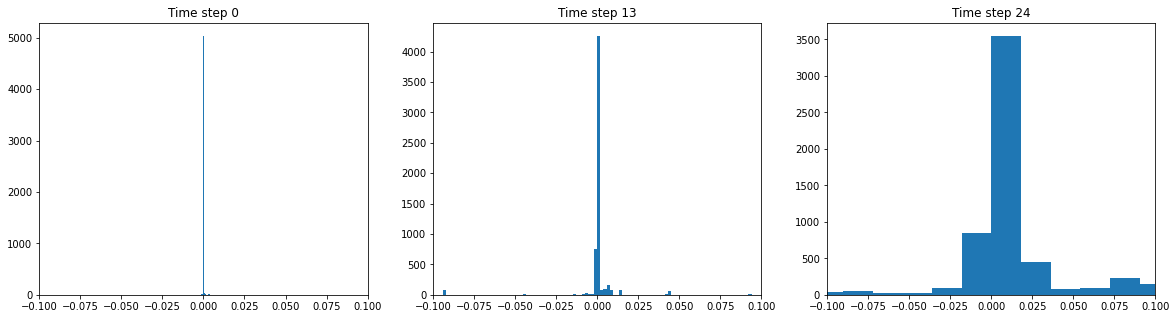

In [34]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(dWhy_list[-1].reshape(-1),100)
plt.title('Time step 0')
plt.xlim(-1e-1, 1e-1)
plt.subplot(1,3,2)
plt.hist(dWhy_list[14].reshape(-1),100)
plt.title('Time step 13')
plt.xlim(-1e-1, 1e-1)
plt.subplot(1,3,3)
plt.hist(dWhy_list[0].reshape(-1),100)
plt.title('Time step 24')
plt.xlim(-1e-1, 1e-1)
plt.show()

Here we can see that the gradients of $W_{y}$ vanish along the time step. We need to notice that the gradients flows from the last time step to the first. This means that the gradeint at the last time step will gradually decrease as it reaches the first time step. This is quite evident from the chart above. 

## Gradients for $W_{h}$

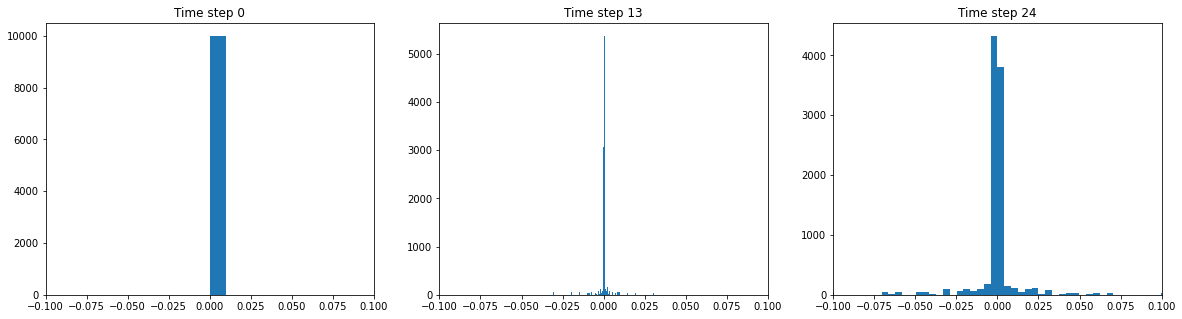

In [35]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(dWhh_list[-1].reshape(-1),100)
plt.title('Time step 0')
plt.xlim(-1e-1, 1e-1)
plt.subplot(1,3,2)
plt.hist(dWhh_list[14].reshape(-1),100)
plt.title('Time step 13')
plt.xlim(-1e-1, 1e-1)
plt.subplot(1,3,3)
plt.hist(dWhh_list[0].reshape(-1),100)
plt.title('Time step 24')
plt.xlim(-1e-1, 1e-1)
plt.show()

We see a similar trend here as well

## Gradients for $W_{x}$

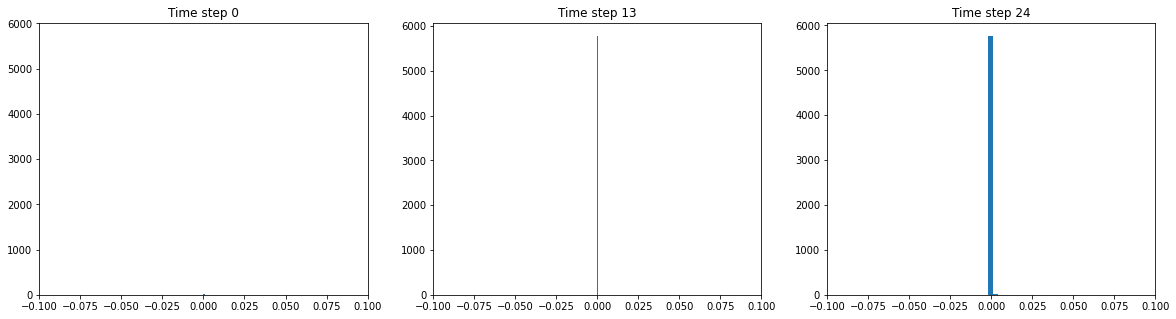

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(dWxh_list[-1].reshape(-1),100)
plt.title('Time step 0')
plt.xlim(-1e-1, 1e-1)
plt.subplot(1,3,2)
plt.hist(dWxh_list[14].reshape(-1),100)
plt.title('Time step 13')
plt.xlim(-1e-1, 1e-1)
plt.subplot(1,3,3)
plt.hist(dWxh_list[0].reshape(-1),100)
plt.title('Time step 24')
plt.xlim(-1e-1, 1e-1)
plt.show()

Here the gradients are negligible in time step 0.